<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/MLPcomparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

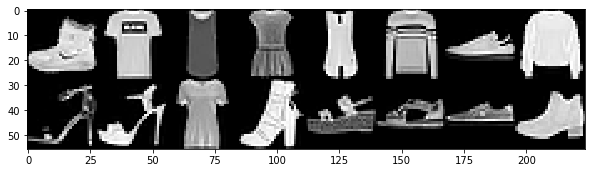

In [0]:
img = utils.make_grid(images, padding=0)
npimg = img.numpy() # img를 넘파이 행렬로 변환
plt.figure(figsize=(10,7))
plt.imshow(np.transpose(npimg, (1,2,0))) # 첫번째, 두번째 차원을 읽어 이미지로 나타냄
plt.show()

In [0]:
# 토치비전과 파이토치 패키지 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

# CUDA(pytorch에서 GPU를 사용하게 해주는 도구)설치 여부를 기준으로 GPU / CPU 사용 결정
USE_CUDA = torch.cuda.is_available()
# DEVICE 변수를 통해 나중에 텐서 및 가중치 연산에서 GPU / CPU 사용결정
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

# 이폭은 학습 데이터 전체를 총 몇 번이나 볼 것인가에 대한 설정
EPOCHS=50
BATCH_SIZE=64

# 데이터 전처리 과정을 적용(이미지 텐서변환, 랜덤으로 뒤집기, 정규화)하여 Fashion MNIST 데이터셋 가져오기 / * 정규화 방식 차이 설명(0~255와 0~1의 차이)
# 학습용 트레닝 셋(Train=True)
train_loader=torch.utils.data.DataLoader(datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=BATCH_SIZE, shuffle=True)
# 성능 평가용 데이터셋(Train=False)
test_loader=torch.utils.data.DataLoader(datasets.FashionMNIST('./.data', train=False, transform=transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])), batch_size=BATCH_SIZE, shuffle=True)

# * 파이토치는 항상 모델 구현 시에 nn.Module을 상속하는 클래스를 생성함 nn 속의 함수들을 이용하기 위함.
class Net(nn.Module):
    # 드롭아웃 확률 = 0.2로 설정, 즉 학습 시 20% 뉴런을 사용하지 않음
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        # 함수 fc1()은 픽셀값 784개를 입력받아 가중치를 행렬곱하고 편향을 더해 값 256개를 출력
        self.fc1 = nn.Linear(784,256)
        # fc2()와 fc3() 함수를 거쳐 마지막에 값 10개를 출력
        self.fc2 = nn.Linear(256,128)
        # 출력값 10개는 각각의 클래스를 나타내며 가장 큰 값이 이 모델의 예측값
        self.fc3 = nn.Linear(128,10)
        self.dropout_p = dropout_p # 드롭아웃 확률
    
    # 순전파
    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
    # 학습모델에서만 드롭아웃을 적용하기 위한 self.training 입력
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training, p=self.dropout_p)
        x = self.fc3(x)
        return x

# 모델 선언
# CUDA를 사용할 경우 GPU를 아닐 경우 CPU로 보내도록 설정
model=Net(dropout_p=0.2).to(DEVICE)
# 최적화 알고리즘으로 파이토치 내장 모듈인 optim.SGD(확률적 경사하강법) 사용
# model.parameters()는 모델 내부의 정보를 넘겨줌, lr=학습률
optimizer=optim.SGD(model.parameters(), lr=0.01)

def train(model, train_loader, optimizer): # 각 인자는 모델, 데이터 공급, 최적화 역할
    model.train() # 모델을 학습 모드로 설정
    # 배치마다의 data, target에 대한 정보를 DEVICE로 보냄
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target=data.to(DEVICE), target.to(DEVICE)
    # 반복 때마다 기울기를 새로 계산(누적하지 않음)하므로 zero_grad() 설정 / * 파이토치에는 기울기 누적을 실행하지 않는 zero_grad 설정
        optimizer.zero_grad()
        output=model(data)
    # 교차 엔트로피 사용하여 오차 구함
    # loss는 미니배치 64개의 오차들의 평균인 하나의 숫자
        loss=F.cross_entropy(output, target)
    # backward 함수를 실행하면 자동으로 기울기가 계산
        loss.backward()
    # 계산한 기울기를 앞서 정의한 알고리즘(SGD)에 맞추어 가중치 수정(매개변수 갱신)
        optimizer.step()

# 이폭이 끝날 때마다 테스트셋으로 모델의 성능 측정하는 evaluate 함수 생성
def evaluate(model, test_loader): # 평가가 목적이므로 최적화는 필요 없음
    model.eval() # 모델을 평가 모드로 변경
    test_loss=0
    correct=0
    # 평가 과정에서는 기울기를 계산하지 않아도 됨
    with torch.no_grad():
        for data, target in test_loader :
            data, target=data.to(DEVICE), target.to(DEVICE)
            output=model(data)
    # 평가를 위해 미니배치들의 평균 대신 합을 받아오도록 reduction='sum' 설정, 즉 모든 오차의 합 출력
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
    # 예측값. output.max()는 가장 큰 값과 그 인덱스를 출력. 그 중 인덱스 이용
            pred=output.max(1,keepdim=True)[1]
    # eq함수는 일치하면 1, 아니면 0 출력. sum함수로 배열 내 값 모두 더하여 배치에서 모델이 정답을 맞힌 개수 구함
            correct += pred.eq(target.view_as(pred)).sum().item()
    # 총 정답 평균을 구하여 정확도를 구함
    test_loss /= len(test_loader.dataset)
    test_accuracy=100.*correct / len(test_loader.dataset)
    return test_loss, test_accuracy


for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer) # 훈련 후 평가
    test_loss, test_accuracy=evaluate(model, test_loader)
    # 오차는 소숫점 4자리까지, 정확도는 소숫점 2자리까지
    print('[{}] Test Loss : {:.4f}, Accuracy : {:.2f}%'.format(epoch, test_loss, test_accuracy))

[1] Test Loss : 0.6489, Accuracy : 76.94%
[2] Test Loss : 0.5316, Accuracy : 81.00%
[3] Test Loss : 0.4900, Accuracy : 82.27%
[4] Test Loss : 0.4596, Accuracy : 83.42%
[5] Test Loss : 0.4409, Accuracy : 84.07%
[6] Test Loss : 0.4241, Accuracy : 84.65%
[7] Test Loss : 0.4108, Accuracy : 85.13%
[8] Test Loss : 0.4078, Accuracy : 85.22%
[9] Test Loss : 0.3958, Accuracy : 85.81%
[10] Test Loss : 0.3901, Accuracy : 85.90%
[11] Test Loss : 0.3854, Accuracy : 85.80%
[12] Test Loss : 0.3769, Accuracy : 86.40%
[13] Test Loss : 0.3757, Accuracy : 86.38%
[14] Test Loss : 0.3664, Accuracy : 86.82%
[15] Test Loss : 0.3639, Accuracy : 86.73%
[16] Test Loss : 0.3592, Accuracy : 87.10%
[17] Test Loss : 0.3567, Accuracy : 86.97%
[18] Test Loss : 0.3551, Accuracy : 87.05%
[19] Test Loss : 0.3590, Accuracy : 87.10%
[20] Test Loss : 0.3478, Accuracy : 87.46%
[21] Test Loss : 0.3458, Accuracy : 87.55%
[22] Test Loss : 0.3430, Accuracy : 87.61%
[23] Test Loss : 0.3519, Accuracy : 87.05%
[24] Test Loss : 0.3